# MSCA 32009 Health Analytics Final Project NLP
* Group 8: Beca Wang, Elly Yang, Jianghong Man
* Date: Mar 18, 2021

## II. Topics - use NLP to find the top 3 trending topics related to Covid-19

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# load package
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

# load data
tweets = pd.read_csv('/content/drive/MyDrive/32009 Health Analytics/data.csv', index_col=0)['text']
tweets.drop_duplicates(inplace = True)
tweets = tweets.str.lower()
tweets_before = tweets.copy()

# popular hashtags
def find_hashtags(tweet): return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
hashtags = tweets.apply(find_hashtags)
pd.Series([k for j in hashtags[hashtags.apply(lambda i: i != [])] for k in j]).value_counts().head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#covid19             2232
#coronavirus         1122
#covid               353 
#protests2020        250 
#blacklivesmatter    173 
dtype: int64

In [ ]:
# clean tweets
def remove_hashtags(tweet):
    tweet = re.sub('# [\w]*', '', tweet)
    tweet = re.sub('#[\w]*', '', tweet)
    return tweet
tweets = tweets.apply(remove_hashtags)

def remove_users(tweet):
    tweet = re.sub('@ [\w]*', '', tweet)
    tweet = re.sub('@[\w]*', '', tweet)
    return tweet
tweets = tweets.apply(remove_users)

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    tweet = tweet.strip('[link]')
    return tweet
tweets = tweets.apply(remove_links)

def remove_words(tweet):
    tweet = re.sub('covid', '', tweet)
    tweet = re.sub('coronavirus', '', tweet)
    tweet = re.sub('corona', '', tweet)
    return tweet
tweets = tweets.apply(remove_words)

tweets = tweets.str.replace('[^a-zA-Z#]', ' ')  # remove nonalpha characters

tweets = tweets.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3])) # remove words with length not greater than 3

def remove_stopwords(tweet): return [i for i in simple_preprocess(tweet) if i not in stopwords.words('english')]
tweets = tweets.apply(remove_stopwords)

tweets[tweets.apply(len) < 3] = np.nan

tweets_after = tweets.apply(lambda x: np.nan if x is np.nan else ' '.join(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


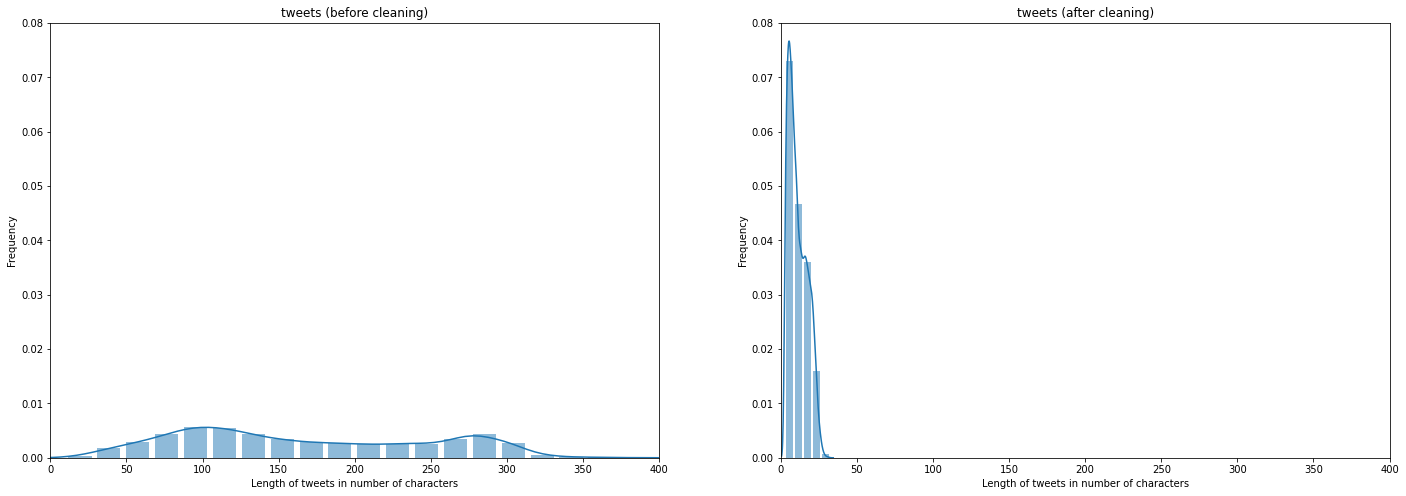

In [ ]:
# visualize cleaning effects
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
sns.distplot(tweets_before.str.len(), bins = 50, hist_kws={'alpha': 0.5,'rwidth':0.8})
plt.title('tweets (before cleaning)')
plt.xlabel('Length of tweets in number of characters')
plt.ylabel('Frequency')
plt.xlim([0,400])
plt.ylim([0,.08])

plt.subplot(1,2,2)
sns.distplot(tweets.str.len(), bins = 5, hist_kws={'alpha': 0.5,'rwidth':0.8})
plt.title('tweets (after cleaning)')
plt.xlabel('Length of tweets in number of characters')
plt.ylabel('Frequency')
plt.xlim([0,400])
plt.ylim([0,.08])

plt.show()

In [ ]:
# text normalization
df = pd.DataFrame({'before cleaning': tweets_before, 'after cleaning': tweets_after, 'tokenization': tweets})
df.dropna(inplace = True)
tweets = df['tokenization']

bi = gensim.models.Phrases(tweets, min_count=10, threshold=100)
bigram_model = gensim.models.phrases.Phraser(bi)
def get_bigram(tweet): return [bigram_model[i] for i in tweet]
bigrams = get_bigram(tweets)

def lemmatization(tweet):
    output = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for i in tweet: output.append([token.lemma_ for token in nlp(' '.join(i)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    return output
tweets_lem = lemmatization(bigrams)
#  [list(x) for x in set(tuple(x) for x in lemmatization(bigrams))]

def stemming(tweet):
    output = []
    for i in tweet: output.append([PorterStemmer().stem(j) for j in i])
    return output
tweets_stem = stemming(tweets_lem)

df['lemmatization'] = tweets_lem
df['stemming'] = tweets_stem
df.reset_index(inplace = True)

In [ ]:
# latent dirichlet allocation (LDA)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='[a-zA-Z0-9]{3,}', analyzer='word')
vec = vectorizer.fit_transform(df['stemming'].apply(lambda x: ' '.join(x)))

from sklearn.decomposition import LatentDirichletAllocation
model = LatentDirichletAllocation(n_components=3, random_state=0)
model.fit_transform(vec)
print('Log Likelihood: ', model.score(vec)) # higher the better
print('Perplexity: ', model.perplexity(vec)) # lower the better

# dominant topic for each tweet
df['Topic (dominant)'] = np.argmax(np.round(model.transform(vec), 2), axis=1)
df.tail()

Log Likelihood:  -1040301.6999366118
Perplexity:  791.5485146029729


,index,before cleaning,after cleaning,tokenization,lemmatization,stemming,Topic (dominant)
21966,23833,"chinese firms say coronavirus vaccine will be ready by end of year, '99 percent' effective\nhttps://t.co/lub5ujrjqr #news #bibleprophecy #truth #knowledge #wisdom #economist #endtimes #revelation",chinese firms vaccine ready year percent effective,"[chinese, firms, vaccine, ready, year, percent, effective]","[chinese, firm, vaccine, ready, year, percent, effective]","[chines, firm, vaccin, readi, year, percent, effect]",2
21967,23834,"coronavirus: b.c. parents weigh risks as classrooms reopen june 1 - [coronavirus], source: global news - https://t.co/gbdnvux3pp https://t.co/gm7blt4rl3",parents weigh risks classrooms reopen june source global news,"[parents, weigh, risks, classrooms, reopen, june, source, global, news]","[parent, weigh, risk, classroom, reopen, source]","[parent, weigh, risk, classroom, reopen, sourc]",0
21968,23835,"opinion | remember, no one is coming to save us https://t.co/dxv0vymgqj",opinion remember coming save,"[opinion, remember, coming, save]","[opinion, remember, come, save]","[opinion, rememb, come, save]",0
21969,23836,contact tracing limits covid-19 cases in northern indian state https://t.co/hecxyzt355 @voanews,contact tracing limits cases northern indian state,"[contact, tracing, limits, cases, northern, indian, state]","[contact_trace, limit, indian, state]","[contact_trac, limit, indian, state]",2
21970,23837,"apart from the tragic human consequences of #covid19, german government’s anti-crisis measures sum up to ""an astronomic value of eur 1.9tr"", according to @deutschebank https://t.co/1gcy825r9x\n\nlet’s make sure we are spending it wisely. \n\n#healthyrecovery https://t.co/mrtyeijh8u",apart tragic human consequences german government anti crisis measures astronomic value according make sure spending wisely,"[apart, tragic, human, consequences, german, government, anti, crisis, measures, astronomic, value, according, make, sure, spending, wisely]","[apart, tragic, human, consequence, german, government, anti, crisis, measure, astronomic, value, accord, make, sure, spending, wisely]","[apart, tragic, human, consequ, german, govern, anti, crisi, measur, astronom, valu, accord, make, sure, spend, wise]",1


In [ ]:
# top 10 keywords for each topic
keywords = []
for topic_weights in model.components_: keywords.append(np.array(vectorizer.get_feature_names()).take((-topic_weights).argsort()[:10]))
pd.DataFrame(keywords, columns = ['Word '+str(i) for i in range(10)], index = ['Topic '+str(i) for i in range(3)]).T

,Topic 0,Topic 1,Topic 2
Word 0,peopl,protest,case
Word 1,say,peopl,death
Word 2,home,riot,peopl
Word 3,work,make,number
Word 4,stay,trump,report
Word 5,still,test,kill
Word 6,need,countri,time
Word 7,help,viru,year
Word 8,viru,busi,die
Word 9,safe,think,month


## III. Sentiment Analysis

In [ ]:
# install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.7.1

# start spark session
import sparknlp
spark = sparknlp.start()
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.11/jars && ls -lt

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
Spark NLP version 2.7.1
Apache Spark version: 2.4.4
total 39960
-rw-r--r-- 1 root root 40918604 Jan  8 21:03 spark-nlp_2.11-2.7.1.jar


analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


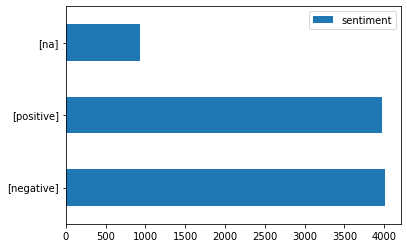

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
topic0 = df[df['Topic (dominant)'] == 0]

sentiment = PretrainedPipeline('analyze_sentiment', lang='en')
topic0['sentiment'] = topic0['after cleaning'].apply(lambda x: sentiment.annotate(x)['sentiment'])
topic0['sentiment'].value_counts().to_frame().plot(kind = 'barh')

analyze_sentimentdl_glove_imdb download started this may take some time.
Approx size to download 154 MB
[OK!]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


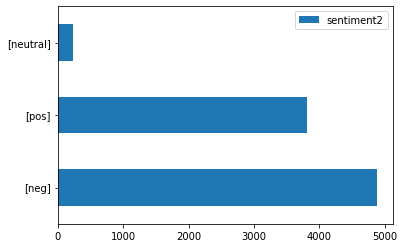

In [ ]:
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic0['sentiment2'] = topic0['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment']) # sentiment_imdb_glove.fullAnnotate(x)[0]['sentiment']
topic0['sentiment2'].value_counts().to_frame().plot(kind = 'barh')

## Reference
* https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/1.SparkNLP_Basics.ipynb#scrollTo=U8AXeuY0_9hx
* https://ourcodingclub.github.io/tutorials/topic-modelling-python/
* https://towardsdatascience.com/religion-on-twitter-5f7b84062304
* https://github.com/HurmetNoka/religion_on_twitter
* https://www.youtube.com/watch?v=T05t-SqKArY
* https://towardsdatascience.com/topic-modeling-and-sentiment-analysis-on-amazon-alexa-reviews-81e5017294b1
